### Final Capstone Group Project

## Load the Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import scipy.stats as stats

## MTA model package
from ChannelAttribution import *

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Version: 2.1.4


In [3]:
## if you use google colab uncomment and run this block 
#from google.colab import drive
#drive.mount('/content/drive')

### Set Random seed 
in order to get same random number for everyone in very run...

In [4]:
# Next command sets the seed to generate the same sequence of pseudorandom 
# numbers every time you run the script and hence it allows to replicate results
# The argument is an arbitrary integer
np.random.seed(2021)

## small example set to understand the output of channel Attribution output

In [5]:
df = pd.DataFrame([["A", 0, 2], ["A > B", 1, 1], ["B", 2, 2]], columns=['channel', 'Conv', 'Null'])
df

,channel,Conv,Null
0,A,0,2
1,A > B,1,1
2,B,2,2


In [6]:
heuristic_models(df,"channel","Conv",flg_adv = False)

,channel_name,first_touch,last_touch,linear_touch
0,A,1.0,0.0,0.5
1,B,2.0,3.0,2.5


In [7]:
test = auto_markov_model(df,
                           "channel",
                           "Conv",
                           var_null = "Null",
                           out_more = True,
                           flg_adv = False)
test['result']

Suggested order: 1
Number of simulations: 100000 - Convergence reached: 1.65% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (3) is reached: 99.99%


,channel_name,total_conversions
0,A,0.756998
1,B,2.243002


In [8]:
test['transition_matrix'].pivot(index = 'channel_from', columns='channel_to', values='transition_probability')

channel_to,(conversion),(null),1,2
channel_from,,,,
(start),NaN,NaN,0.5,0.5
1,NaN,0.5,NaN,0.5
2,0.5,0.5,NaN,NaN


In [9]:
test['removal_effects']

,channel_name,removal_effect
0,A,0.337493
1,B,1.000000


## Read the data

In [10]:
Data = pd.read_csv('MTA_Input.csv')
channel = pd.read_csv("NintendoMapping.csv")

### review columns in Data
- detialed data review, check [Data_Review_1.ipynb](Data_Review_1.ipynb) or the Tableau [Dashboard](DV_Tableau/AdFlow%20Group%20Assignment.twbx)

In [11]:
print(Data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100520 entries, 0 to 100519
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   path_id            100520 non-null  int64 
 1   user_id            100520 non-null  object
 2   converters         100520 non-null  int64 
 3   nonconverters      100520 non-null  int64 
 4   num_search_ads     100520 non-null  int64 
 5   num_display_ads    100520 non-null  int64 
 6   num_video_ads      100520 non-null  int64 
 7   num_sponsored_ads  100520 non-null  int64 
 8   last_touch         100520 non-null  object
 9   first_touch        100520 non-null  object
 10  promotion          100520 non-null  int64 
 11  phone              100520 non-null  int64 
 12  web                100520 non-null  int64 
 13  str_path           100520 non-null  object
 14  path_clean         100520 non-null  object
dtypes: int64(10), object(5)
memory usage: 11.5+ MB
None


In [12]:
## creat mapping for channel names
channel_map = {'A_FTV-DIS':'Awareness Fire TV Display Ads',
 'A_SA': 'Awareness Search Ads',
 'C_OLV': 'Consideration Online Video Ads',
 'C_DSP-DIS': 'Consideration DSP Display Ads',
 'P_DSP-DIS': 'Purchase DSP Display Ads',
 'P_SP': 'Purchase Sponsored Products Ads',
 'P_OO-SA': 'Purchase O&O Search Ads'}

## below two rows give same output, but the second one is faster
channel[channel['internal'] == 'A_SA'].external
channel_map['A_SA']

'Awareness Search Ads'

### convert the paths to the required format for ChannelAttribute

In [13]:
# function to convert str_path to the required format for ChannelAttribute
def str_to_path(str_path):
    touchpoints = str_path.split("@")
    arr = [None] * len(touchpoints)
    for tp in touchpoints:
        i, ch = tp.split('&')
        i = int(i) - 1
        arr[i] = channel_map[ch]
    return " > ".join(str(x) for x in arr)

## replace path_clean with the format for ChannelAttibute
Data["path_clean"] = Data.str_path.apply(str_to_path)

#### Review the converted data

In [14]:
Data[["path_clean", "converters", "nonconverters"]].head()

,path_clean,converters,nonconverters
0,Awareness Search Ads > Awareness Search Ads > ...,0,2
1,Purchase DSP Display Ads > Purchase DSP Displa...,0,3
2,Purchase O&O Search Ads > Purchase O&O Search ...,0,2
3,Purchase O&O Search Ads > Purchase O&O Search ...,0,2
4,Purchase DSP Display Ads > Awareness Search Ads,2,3228


### generate random revenue for each path
- code copied from examples scripts in DUR class in M4. 
- Making this assumtion because we dont have this data in our data set.
- If we get the real data later on, we can run with the real data instead of the assumtion. 

In [15]:
## Generate total revenue values for one particular path
## Assume it's normal distribution
mu, sigma = 300, 100 ## mu = mean, sigma = standard deviation 
Data['total_conv_values'] = stats.norm.rvs(loc=mu, scale=sigma, size=Data.shape[0])

## The negative revenue are replaced by 0s, and if  converters = 0 -> revenue = 0
Data['total_conv_values']=[max(round(d,2),0) for d in Data['total_conv_values']] * Data.converters

#### Review the data

In [16]:
Data[["path_clean", "converters", "nonconverters", 'total_conv_values']].head(10)

,path_clean,converters,nonconverters,total_conv_values
0,Awareness Search Ads > Awareness Search Ads > ...,0,2,0.00
1,Purchase DSP Display Ads > Purchase DSP Displa...,0,3,0.00
2,Purchase O&O Search Ads > Purchase O&O Search ...,0,2,0.00
3,Purchase O&O Search Ads > Purchase O&O Search ...,0,2,0.00
4,Purchase DSP Display Ads > Awareness Search Ads,2,3228,711.18
5,Awareness Search Ads > Awareness Search Ads > ...,0,2,0.00
6,Awareness Search Ads > Awareness Search Ads > ...,0,2,0.00
7,Awareness Search Ads > Awareness Search Ads > ...,0,3,0.00
8,Consideration DSP Display Ads > Consideration ...,0,2,0.00
9,Consideration DSP Display Ads > Consideration ...,0,7,0.00


In [17]:
Data[Data['converters']>0][["path_clean", "converters", "nonconverters", 'total_conv_values']].head(10)

,path_clean,converters,nonconverters,total_conv_values
4,Purchase DSP Display Ads > Awareness Search Ads,2,3228,711.18
74,Purchase DSP Display Ads > Purchase DSP Displa...,5,1017,793.70
172,Purchase O&O Search Ads > Purchase O&O Search ...,5,545,1496.20
208,Awareness Search Ads > Awareness Search Ads > ...,3,94,1032.45
270,Purchase O&O Search Ads > Consideration DSP Di...,2,660,620.12
495,Purchase O&O Search Ads > Purchase O&O Search ...,2,68,337.50
579,Purchase O&O Search Ads > Purchase O&O Search ...,10,145,2706.70
589,Purchase O&O Search Ads > Purchase O&O Search ...,3,366,640.44
607,Purchase Sponsored Products Ads > Purchase Spo...,2,3,614.72
696,Consideration Online Video Ads > Purchase Spon...,7,199,1892.38


## Model using ChannelAttribution

In [18]:
#ESTIMATE HEURISTIC MODELS
H = heuristic_models(Data,"path_clean","converters",
                     var_value = "total_conv_values",
                     flg_adv = False)
H


,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Awareness Search Ads,2250.0,688923.36,2044.0,619169.12,2171.966667,6.619017e+05
1,Purchase DSP Display Ads,2265.0,756000.56,2094.0,712760.83,2171.966667,7.338533e+05
2,Purchase O&O Search Ads,17097.0,5415355.95,16617.0,5296288.39,17059.280952,5.411420e+06
3,Consideration DSP Display Ads,4687.0,1739969.72,5039.0,1868735.27,4901.533333,1.815840e+06
4,Purchase Sponsored Products Ads,60473.0,15008026.28,61004.0,15118085.72,60481.085714,1.498885e+07
5,Consideration Online Video Ads,187.0,64616.51,161.0,57853.05,173.166667,6.102782e+04


In [19]:
#ESTIMATE MARKOV MODEL
Auto_M = auto_markov_model(Data,
                           "path_clean",
                           "converters",
                           var_value = "total_conv_values",
                           var_null = "nonconverters",
                           out_more = True,
                           flg_adv = False)

Suggested order: 3
Number of simulations: 100000 - Reaching convergence (wait...): 12.91% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 8.49% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 6.68% > 5.00%
Number of simulations: 337500 - Convergence reached: 4.29% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (7) is reached: 99.99%


In [20]:
Auto_M['result']

,channel_name,total_conversions,total_conversion_value
0,Awareness Search Ads,1663.868077,5.171026e+05
1,Purchase DSP Display Ads,1751.440081,6.013987e+05
2,Purchase O&O Search Ads,19353.412890,6.087482e+06
3,Consideration DSP Display Ads,4728.888218,1.768974e+06
4,Purchase Sponsored Products Ads,59461.390735,1.469793e+07
5,Consideration Online Video Ads,0.000000,0.000000e+00


In [21]:
#Auto_M['transition_matrix']
round(Auto_M['transition_matrix'].pivot(index = 'channel_from', columns='channel_to', values='transition_probability'),3)

channel_to,(conversion),(null),1,1 1,1 1 1,1 1 2,1 1 3,1 1 4,1 1 5,1 1 6,...,6 5 3,6 5 4,6 5 5,6 6,6 6 1,6 6 2,6 6 3,6 6 4,6 6 5,6 6 6
channel_from,,,,,,,,,,,,,,,,,,,,,
(start),NaN,NaN,0.053,0.034,0.075,0.000,0.001,0.001,0.000,0.0,...,0.0,0.000,0.000,0.002,0.000,0.000,0.00,0.001,0.000,0.004
1,0.002,0.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1 1,0.002,0.998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1 1 1,0.001,0.968,NaN,NaN,NaN,0.004,0.008,0.015,0.004,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1 1 2,0.002,0.609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6 6 2,NaN,0.529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6 6 3,NaN,0.609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6 6 4,0.000,0.563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#Auto_M['transition_matrix'].to_csv("TransitionMatrix.csv")
TM = Auto_M['transition_matrix']
TM[(TM['channel_to'] == '(conversion)') & (TM['transition_probability'] >= 0.05)]


,channel_from,channel_to,transition_probability
476,5 5 5,(conversion),0.118646
504,3 5 5,(conversion),0.064873
526,5 5 3,(conversion),0.076305
588,3 5 3,(conversion),0.064928
645,5 3 5,(conversion),0.079877
696,4 5 5,(conversion),0.050000
762,3 5,(conversion),0.055546
782,1 5 3,(conversion),0.100000
817,6 5 5,(conversion),0.061224
855,5 2 5,(conversion),0.052632


In [23]:
## if removel effect of a channel = 1, it means by removing that channel no conversion would happen
## similarly, if removel effect = 0, that channel has no impact to conversion 
## larger removel effect = more importance to conversion 
Auto_M['removal_effects'].to_clipboard(sep='\t', index=False) 

In [24]:
## Find the minimum Markov Model order that gives a good representation of customers’ behaviour for data considered. 
## It requires paths that do not lead to conversion as input. Minimum order is found maximizing a penalized area under ROC curve.
order = choose_order(Data,
                     "path_clean",
                     "converters",
                     var_null = "nonconverters",
                     max_order=10,
                     flg_adv=False)


Suggested order: 3


In [25]:
#ESTIMATE MARKOV MODEL
# using default order = 1; however, by using the choose_order function, we found that the suggested order = 3
M = markov_model(Data,"path_clean","converters",
                 var_value = "total_conv_values",
                 var_null = "nonconverters",
                 flg_adv = False)
M

Number of simulations: 100000 - Reaching convergence (wait...): 28.22% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 22.27% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 18.59% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 14.60% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 11.71% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 9.09% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 7.46% > 5.00%
Number of simulations: 1708593 - Reaching convergence (wait...): 6.25% > 5.00%
Number of simulations: 2562889 - Reaching convergence (wait...): 5.18% > 5.00%
Number of simulations: 3844333 - Convergence reached: 4.12% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (7) is reached: 99.99%


,channel_name,total_conversions,total_conversion_value
0,Awareness Search Ads,2421.404974,6.884363e+05
1,Purchase DSP Display Ads,3749.651392,1.213933e+06
2,Purchase O&O Search Ads,17907.817856,5.570288e+06
3,Consideration DSP Display Ads,5483.424371,1.963679e+06
4,Purchase Sponsored Products Ads,57114.595972,1.413777e+07
5,Consideration Online Video Ads,282.105434,9.878539e+04


In [26]:
#PLOT TOTAL CONVERSIONS
#R = pd.merge(H,M,on="channel_name",how="inner")
R = pd.merge(H,Auto_M['result'],on="channel_name",how="inner")
R1 = R[["channel_name","first_touch_conversions","last_touch_conversions","linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]
R1 = R1.sort_values('first_touch', ascending=False)
round(R1)

,channel_name,first_touch,last_touch,linear_touch,markov_model
4,Purchase Sponsored Products Ads,60473.0,61004.0,60481.0,59461.0
2,Purchase O&O Search Ads,17097.0,16617.0,17059.0,19353.0
3,Consideration DSP Display Ads,4687.0,5039.0,4902.0,4729.0
1,Purchase DSP Display Ads,2265.0,2094.0,2172.0,1751.0
0,Awareness Search Ads,2250.0,2044.0,2172.0,1664.0
5,Consideration Online Video Ads,187.0,161.0,173.0,0.0


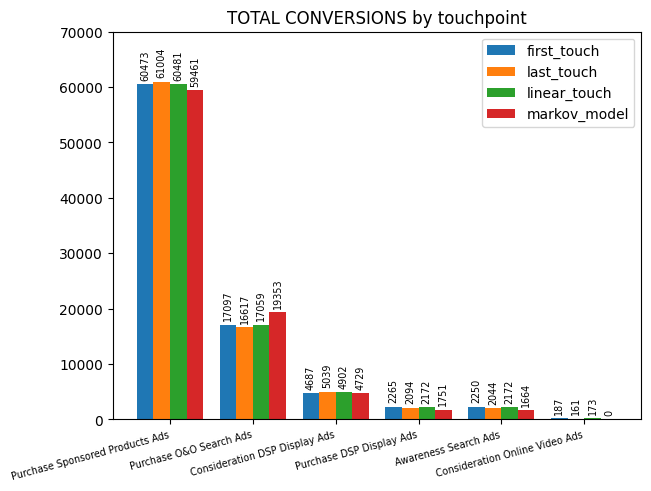

In [27]:
x = np.arange(len(R1.channel_name))  # the label locations
width = 0.2  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch","linear_touch","markov_model"]:
    offset = width * multiplier
    rects = ax.bar(x = x+offset, height= round(R1[touch]), width = width, label=touch)
    ax.bar_label(rects, fontsize = 'x-small',rotation=90, padding=3)
    multiplier += 1

#ax.get_yaxis().set_visible(False)
ax.set_title('TOTAL CONVERSIONS by touchpoint')
ax.set_xticks(x+width, R1.channel_name, fontsize = 'x-small',rotation=15, horizontalalignment='right')
ax.legend(loc='upper right', ncols=1)
ax.set_ylim([0, 70000])

plt.show()

/var/folders/qv/t2vwkpks13lc6qj9vrjf5qf80000gn/T/ipykernel_93201/1444401091.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


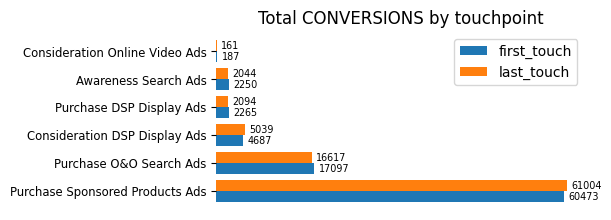

In [28]:
y = np.arange(len(R1.channel_name))  # the label locations
height = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch"]:
    offset = height * multiplier
    rects = ax.barh(y = y+offset, width= round(R1[touch],3), height = height, label=touch)
    ax.bar_label(rects, fontsize = 'x-small', padding=3,fmt='%.0f')
    multiplier += 1

ax.set_title('Total CONVERSIONS by touchpoint')
ax.set_yticks(y+width, R1.channel_name, fontsize = 'small') #,horizontalalignment='right')
ax.legend(loc='upper right', ncols=1)
#ax.set_xlim([0, 5.5])
ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout()
fig.set_size_inches(6, 2)
plt.show()

In [29]:
## same plot using plotly
# R1=pd.melt(R1, id_vars="channel_name")

# data = [dict(
#     type = "histogram",
#     histfunc="sum",
#     x = R1.channel_name,
#     y = R1.value,
#     transforms = [dict(
#         type = "groupby",
#         groups = R1.variable,
#         )],
# )]

# fig = dict({"data":data})
# pio.show(fig,validate=False) 

### Plot the random generated revenue output
The plot below shows the revenue by different measurement. 
- revenue is randome generated using normal distribution
- Doesn't look to different than the conversion plot
- Good to talk about this attempt in the report/presentation
- *DO NOT* use this to make decision/recommandation for the client

In [30]:
#PLOT REVENUES
R2 = R[["channel_name","first_touch_value","last_touch_value", "linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]


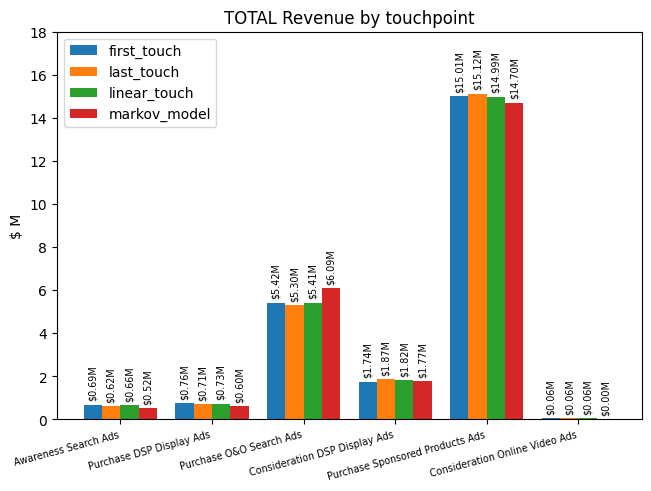

In [31]:
x = np.arange(len(R2.channel_name))  # the label locations
width = 0.2  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch","linear_touch","markov_model"]:
    offset = width * multiplier
    rects = ax.bar(x = x+offset, height= R2[touch]/1000000, width = width, label=touch)
    ax.bar_label(rects, fontsize = 'x-small',rotation=90, padding=3, fmt='${:01.2f}M')
    multiplier += 1

#ax.get_yaxis().set_visible(False)
ax.set_ylabel('$ M')
ax.set_title('TOTAL Revenue by touchpoint')
ax.set_xticks(x+width, R2.channel_name, fontsize = 'x-small',rotation=15, horizontalalignment='right')
ax.legend(loc='upper left', ncols=1)
ax.set_ylim([0, 18])

plt.show()

In [32]:
## same plot using plotly
# R2=pd.melt(R2, id_vars="channel_name")

# data = [dict(
#     type = "histogram",
#     histfunc="sum",
#     x = R2.channel_name,
#     y = R2.value,
#     transforms = [dict(
#         type = "groupby",
#         groups = R2.variable,
#     )],
# )]

# fig = dict({"data":data})
# pio.show(fig,validate=False)

## Transition matrix when order = 1

In [33]:
## Transition matrix when order = 1
T = transition_matrix(Data,
                      "path_clean",
                      "converters",
                      var_null = "nonconverters",
                      flg_adv = False)
T['channels']

,id_channel,channel_name
0,1,Awareness Search Ads
1,2,Purchase DSP Display Ads
2,3,Purchase O&O Search Ads
3,4,Consideration DSP Display Ads
4,5,Purchase Sponsored Products Ads
5,6,Consideration Online Video Ads


In [34]:
round(T['transition_matrix'].pivot(index = 'channel_from', columns='channel_to', values='transition_probability'),3)

channel_to,(conversion),(null),1,2,3,4,5,6
channel_from,,,,,,,,
(start),NaN,NaN,0.169,0.096,0.381,0.156,0.181,0.016
1,0.001,0.358,0.623,0.002,0.005,0.008,0.002,0.000
2,0.001,0.414,0.019,0.401,0.099,0.057,0.004,0.006
3,0.003,0.489,0.012,0.037,0.411,0.040,0.007,0.001
4,0.002,0.438,0.012,NaN,NaN,0.543,0.005,NaN
5,0.037,0.768,0.003,0.001,0.017,0.007,0.167,0.000
6,0.001,0.368,0.016,0.037,0.016,0.093,0.002,0.468


Also check [this spreadsheet](MTA_transition_eg_cal.xlsx) to explore the usage of transition matrix (order = 1). 

# Conversion Rate

## Conversion Rate by First-/Last- Touch
in the below function conv_pct_by_touch calculate the conversion rate by first-/last-touch for each channel. 

In [35]:
def conv_pct_by_touch(data, touch):
    stat_data = Data.groupby(touch).agg(
        path_count = pd.NamedAgg(column='path_id', aggfunc='count'),
        conversion = pd.NamedAgg(column='converters', aggfunc='sum'),
        non_conversion = pd.NamedAgg(column='nonconverters', aggfunc="sum"))
    stat_data['conversion_pct'] = round(stat_data.conversion/(stat_data.conversion + stat_data.non_conversion) *100, 3)
    stat_data['non_conversion_pct'] = round(stat_data.non_conversion/(stat_data.conversion + stat_data.non_conversion)*100, 3)
    stat_data = stat_data.reset_index().rename(columns={touch: "Channel"})
    
    return stat_data

### by First Touch

In [36]:
touch = 'first_touch'
conv_pct_by_touch(Data, touch)

,Channel,path_count,conversion,non_conversion,conversion_pct,non_conversion_pct
0,Awareness Search Ads,23951,2250,1208854,0.186,99.814
1,Consideration DSP Display Ads,14437,4687,1119496,0.417,99.583
2,Consideration Online Video Ads,4815,187,116881,0.160,99.840
3,Purchase DSP Display Ads,17973,2265,690445,0.327,99.673
4,Purchase O&O Search Ads,36591,17097,2719053,0.625,99.375
5,Purchase Sponsored Products Ads,2753,60473,1241892,4.643,95.357


### by Last Touch

In [37]:
touch = 'last_touch'
conv_pct_by_touch(Data, touch)

,Channel,path_count,conversion,non_conversion,conversion_pct,non_conversion_pct
0,Awareness Search Ads,29237,2044,1280959,0.159,99.841
1,Consideration DSP Display Ads,33431,5039,1408559,0.356,99.644
2,Consideration Online Video Ads,2221,161,90854,0.177,99.823
3,Purchase DSP Display Ads,12345,2094,617003,0.338,99.662
4,Purchase O&O Search Ads,20133,16617,2437927,0.677,99.323
5,Purchase Sponsored Products Ads,3153,61004,1261319,4.613,95.387


In [38]:
Conv_pct = pd.merge(conv_pct_by_touch(Data, 'first_touch').rename(columns={'conversion_pct': 'first_touch'}),
                   conv_pct_by_touch(Data, 'last_touch').rename(columns={'conversion_pct': 'last_touch'}),
                   on="Channel",how="inner")[['Channel','first_touch','last_touch']]\
                .sort_values('first_touch', ascending=False)
Conv_pct

,Channel,first_touch,last_touch
5,Purchase Sponsored Products Ads,4.643,4.613
4,Purchase O&O Search Ads,0.625,0.677
1,Consideration DSP Display Ads,0.417,0.356
3,Purchase DSP Display Ads,0.327,0.338
0,Awareness Search Ads,0.186,0.159
2,Consideration Online Video Ads,0.160,0.177


In [39]:
""" x = np.arange(len(Conv_pct.Channel))  # the label locations
width = 0.4  # the width of the bars
multiplier = -0.5

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch"]:
    offset = width * multiplier
    rects = ax.bar(x = x+offset, height= round(Conv_pct[touch],3), width = width, label=touch)
    ax.bar_label(rects, fontsize = 'x-small',rotation=90, padding=3)
    multiplier += 1

#ax.get_yaxis().set_visible(False)
ax.set_title('CONVERSIONS rate by touchpoint')
ax.set_xticks(x+width, Conv_pct.Channel, fontsize = 'x-small',rotation=15, horizontalalignment='right')
ax.legend(loc='upper left', ncols=1)
#ax.set_ylim([0, 70000])

plt.show() """

' x = np.arange(len(Conv_pct.Channel))  # the label locations\nwidth = 0.4  # the width of the bars\nmultiplier = -0.5\n\nfig, ax = plt.subplots(layout=\'constrained\')\n\nfor touch in ["first_touch", "last_touch"]:\n    offset = width * multiplier\n    rects = ax.bar(x = x+offset, height= round(Conv_pct[touch],3), width = width, label=touch)\n    ax.bar_label(rects, fontsize = \'x-small\',rotation=90, padding=3)\n    multiplier += 1\n\n#ax.get_yaxis().set_visible(False)\nax.set_title(\'CONVERSIONS rate by touchpoint\')\nax.set_xticks(x+width, Conv_pct.Channel, fontsize = \'x-small\',rotation=15, horizontalalignment=\'right\')\nax.legend(loc=\'upper left\', ncols=1)\n#ax.set_ylim([0, 70000])\n\nplt.show() '

/var/folders/qv/t2vwkpks13lc6qj9vrjf5qf80000gn/T/ipykernel_93201/2420392977.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


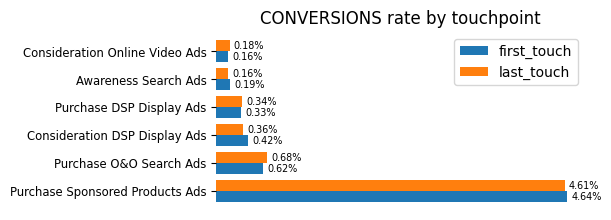

In [40]:
y = np.arange(len(Conv_pct.Channel))  # the label locations
height = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch"]:
    offset = height * multiplier
    rects = ax.barh(y = y+offset, width= Conv_pct[touch], height = height, label=touch)
    ax.bar_label(rects, fontsize = 'x-small', padding=3,fmt='%.2f%%')
    multiplier += 1

ax.set_title('CONVERSIONS rate by touchpoint')
ax.set_yticks(y+width, Conv_pct.Channel, fontsize = 'small') #,horizontalalignment='right')
ax.legend(loc='upper right', ncols=1)
#ax.set_xlim([0, 5.5])
ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.tight_layout()
fig.set_size_inches(6, 2)
plt.show()

In [41]:
TM_1 = T['transition_matrix']
TM_1 = TM_1[(TM_1['channel_to'] == '(conversion)')]
TM_1['channel_from'] = TM_1['channel_from'].astype(int)
TM_1['transition_probability'] = TM_1['transition_probability'] * 100
#T['channels']

Conv_pct = \
Conv_pct.merge(
    TM_1.merge(T['channels'], 
            left_on='channel_from', 
            right_on='id_channel')[['channel_name','transition_probability']]\
                .rename(columns={'channel_name': 'Channel', 'transition_probability':'Transition measure'}), 
    on = 'Channel')

Conv_pct

/var/folders/qv/t2vwkpks13lc6qj9vrjf5qf80000gn/T/ipykernel_93201/1684718100.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TM_1['channel_from'] = TM_1['channel_from'].astype(int)
/var/folders/qv/t2vwkpks13lc6qj9vrjf5qf80000gn/T/ipykernel_93201/1684718100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TM_1['transition_probability'] = TM_1['transition_probability'] * 100


,Channel,first_touch,last_touch,Transition measure
0,Purchase Sponsored Products Ads,4.643,4.613,3.712686
1,Purchase O&O Search Ads,0.625,0.677,0.333574
2,Consideration DSP Display Ads,0.417,0.356,0.156843
3,Purchase DSP Display Ads,0.327,0.338,0.140341
4,Awareness Search Ads,0.186,0.159,0.057180
5,Consideration Online Video Ads,0.160,0.177,0.065127


/var/folders/qv/t2vwkpks13lc6qj9vrjf5qf80000gn/T/ipykernel_93201/275364219.py:24: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


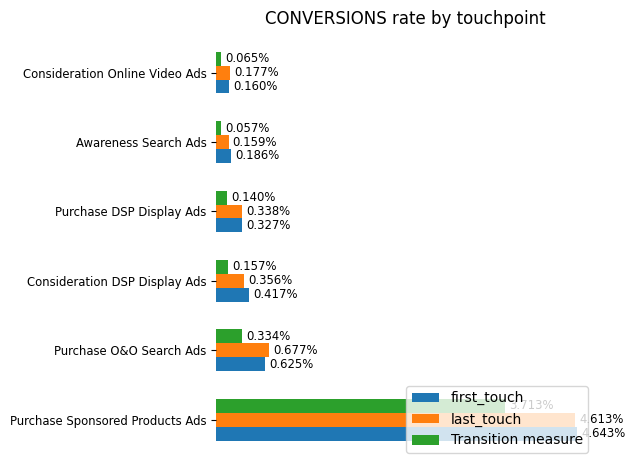

In [42]:
y = np.arange(len(Conv_pct.Channel))  # the label locations
height = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for touch in ["first_touch", "last_touch", 'Transition measure']:
    offset = height * multiplier
    rects = ax.barh(y = y+offset, width= round(Conv_pct[touch],3), height = height, label=touch)
    ax.bar_label(rects, fontsize = 'small', padding=3,fmt='%.3f%%')
    multiplier += 1

ax.set_title('CONVERSIONS rate by touchpoint')
ax.set_yticks(y+width, Conv_pct.Channel, fontsize = 'small') #,horizontalalignment='right')
ax.legend(loc='lower right', ncols=1)
#ax.set_xlim([0, 5.5])
ax.get_xaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


fig.tight_layout()
plt.show()

## Conversion Rate using count of each Ad in the paths
Copied from Monewa

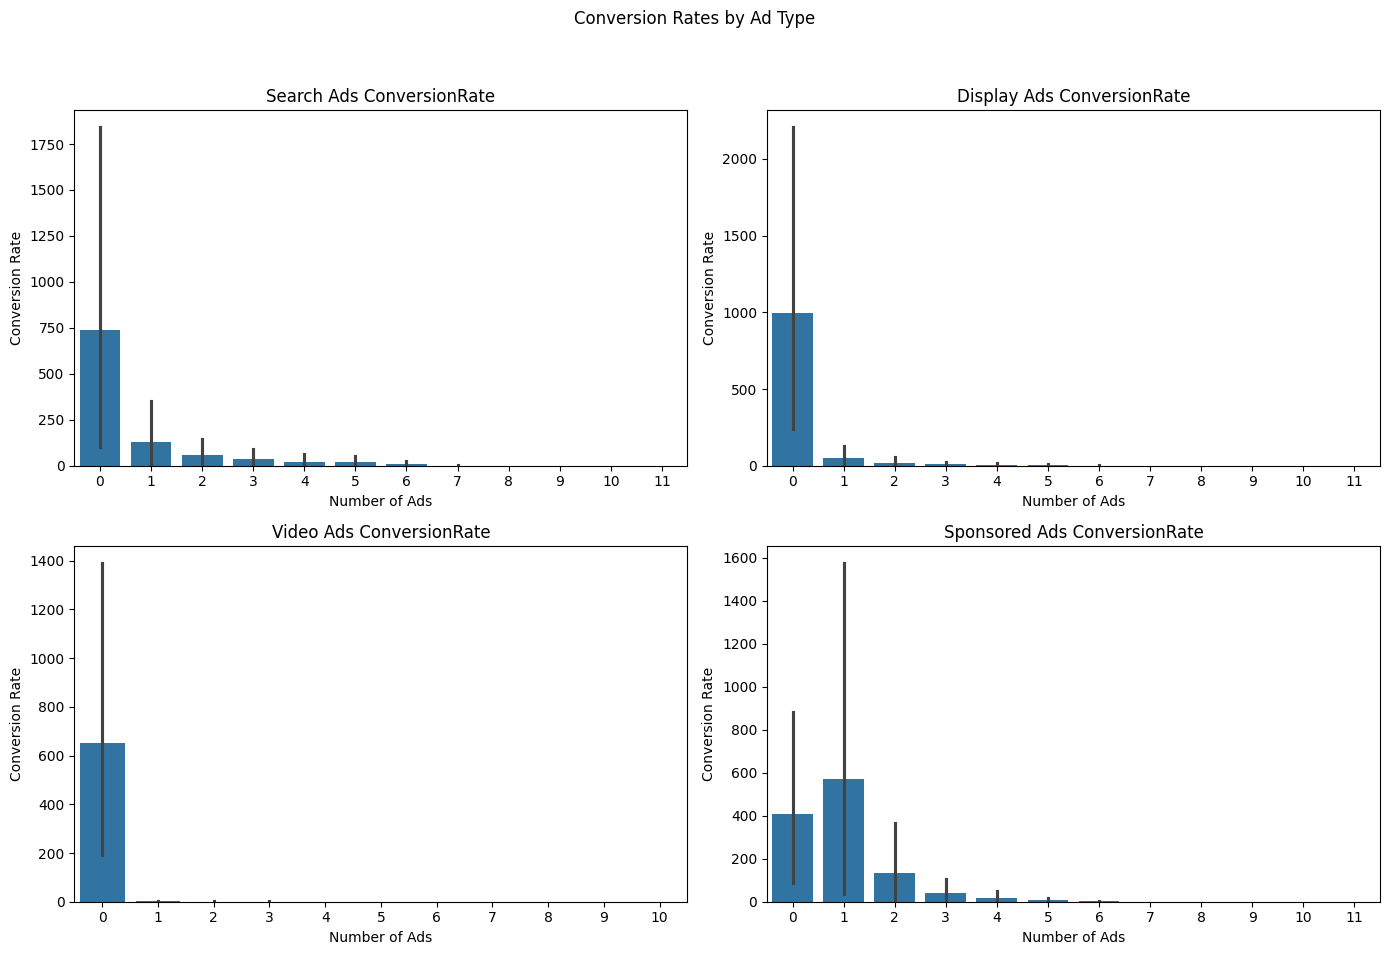

In [43]:
# Setting up the visual style for the plots
#sns.set_style("whitegrid")

# Summarizing data for ad type effectiveness
ad_types = ['num_search_ads', 'num_display_ads', 'num_video_ads','num_sponsored_ads']
ad_type_summaries = Data[ad_types +['converters']].groupby(ad_types).sum().reset_index()

# Calculating conversion rates for each ad type
for ad_type in ad_types:
    ad_type_summaries[f'{ad_type}_conv_rate'] = \
        ad_type_summaries['converters'] / (ad_type_summaries[ad_type] + 1) # Adding 1 to avoid division by zero

# Plotting conversion rates for each ad type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Conversion Rates by Ad Type')

for i, ad_type in enumerate(ad_types):
    sns.barplot(data=ad_type_summaries, x=ad_type, y=f'{ad_type}_conv_rate',
    ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(ad_type.replace('num_', '').replace('_', ' ').title() + ' ConversionRate')
    axes[i//2, i%2].set_xlabel('Number of Ads')
    axes[i//2, i%2].set_ylabel('Conversion Rate')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Conversion Rate of Each unique Path
copied from Zach

In [44]:
# Percentage of conversion that each channel is responsible for

# Calculate conversion rate
Data["conversion_rate"] = Data["converters"] / (
    Data["converters"] + Data["nonconverters"]
)

# Normalize total conversion values by the number of converters to get average value per conversion
Data["avg_value_per_conversion"] = Data["total_conv_values"] / Data["converters"]

# Now, sort by the top converting paths
top_converting_paths = Data[Data["converters"] > 0].sort_values(
    by="converters", ascending=False
)

# Select the top 10 converting paths
top_converting_paths = top_converting_paths.head(10)

# Show the results
top_converting_paths[
    [
        "path_clean",
        "converters",
        "nonconverters",
        "conversion_rate",
        "avg_value_per_conversion",
    ]
]

,path_clean,converters,nonconverters,conversion_rate,avg_value_per_conversion
62609,Purchase Sponsored Products Ads,40234,1028096,0.037661,264.13
71733,Purchase O&O Search Ads,6733,1551080,0.004322,377.85
27622,Purchase Sponsored Products Ads > Purchase Spo...,5930,65214,0.083352,185.16
66877,Purchase Sponsored Products Ads > Purchase Spo...,5898,65034,0.083150,164.72
13512,Consideration DSP Display Ads,2003,495553,0.004026,416.72
44280,Purchase O&O Search Ads > Purchase O&O Search Ads,1594,178511,0.008850,300.86
8680,Purchase O&O Search Ads > Purchase O&O Search Ads,1566,177574,0.008742,239.34
38646,Purchase DSP Display Ads,994,290967,0.003405,382.29
58501,Awareness Search Ads,671,382056,0.001753,313.42
10659,Purchase Sponsored Products Ads > Purchase Spo...,663,4945,0.118224,205.40


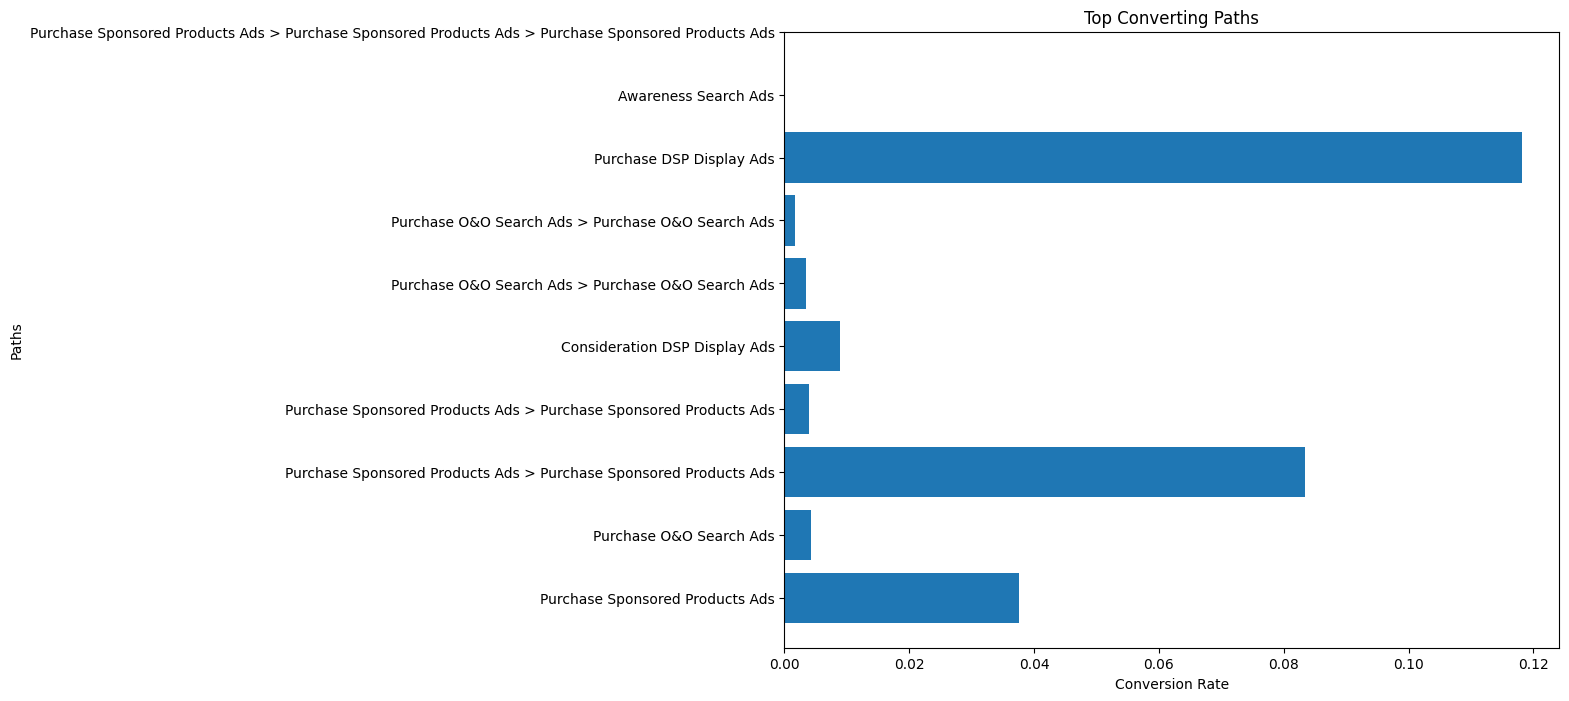

In [45]:

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(top_converting_paths['path_clean'], top_converting_paths['conversion_rate'])

# Add labels and title
plt.xlabel('Conversion Rate')
plt.ylabel('Paths')
plt.title('Top Converting Paths')

# Adjust the y-axis to show the full path names
plt.yticks(ticks=range(len(top_converting_paths)), labels=top_converting_paths['path_clean'])

# Show the plot
plt.show()
